## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
from numpy import concatenate
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from technicalindicators import TechnicalIndicators
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import keras
import yfinance as yf

## Fetching Tesla data

In [2]:
df = yf.download('TSLA', start='2010-01-01', end='2021-04-17')

[*********************100%***********************]  1 of 1 completed


In [3]:
data = df.sort_values('Date', ascending=True)
data = data.reset_index()

## Getting train and test features

In [4]:
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)
dataset = new_data.values

## Scaling data 

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
train= scaled_data[:int(df.shape[0]*0.8)]
valid = scaled_data[int(df.shape[0]*0.8):]

## Reshaping data to fit to LSTM and time step is 60

In [6]:
x_train,y_train,x_test,y_test = [],[],[],[]
for i in range(60,train.shape[0]):
    x_train.append(train[i-60:i,0])
    y_train.append(train[i,0])

for z in range(60,valid.shape[0]):
    x_test.append(valid[z-60:z,0])
    y_test.append(valid[z,0])

## Splitting train and test data

In [7]:
x_train, y_train,x_test,y_test = np.array(x_train), np.array(y_train),np.array(x_test),np.array(y_test)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

## Defining LSTM models and fitting train data to it

Epoch 1/50
30/30 [==============================] - 1s 46ms/step - loss: 1.7456e-04 - val_loss: 0.0530
Epoch 2/50
30/30 [==============================] - 0s 10ms/step - loss: 7.3892e-04 - val_loss: 0.0603
Epoch 3/50
30/30 [==============================] - 0s 10ms/step - loss: 4.3658e-04 - val_loss: 0.0426
Epoch 4/50
30/30 [==============================] - 0s 10ms/step - loss: 4.8626e-04 - val_loss: 0.0361
Epoch 5/50
30/30 [==============================] - 0s 10ms/step - loss: 3.9514e-04 - val_loss: 0.0278
Epoch 6/50
30/30 [==============================] - 0s 10ms/step - loss: 3.6634e-04 - val_loss: 0.0194
Epoch 7/50
30/30 [==============================] - 0s 10ms/step - loss: 2.2012e-04 - val_loss: 0.0160
Epoch 8/50
30/30 [==============================] - 0s 11ms/step - loss: 1.3130e-04 - val_loss: 0.0140
Epoch 9/50
30/30 [==============================] - 0s 10ms/step - loss: 9.0922e-05 - val_loss: 0.0143
Epoch 10/50
30/30 [==============================] - 0s 10ms/step - loss:

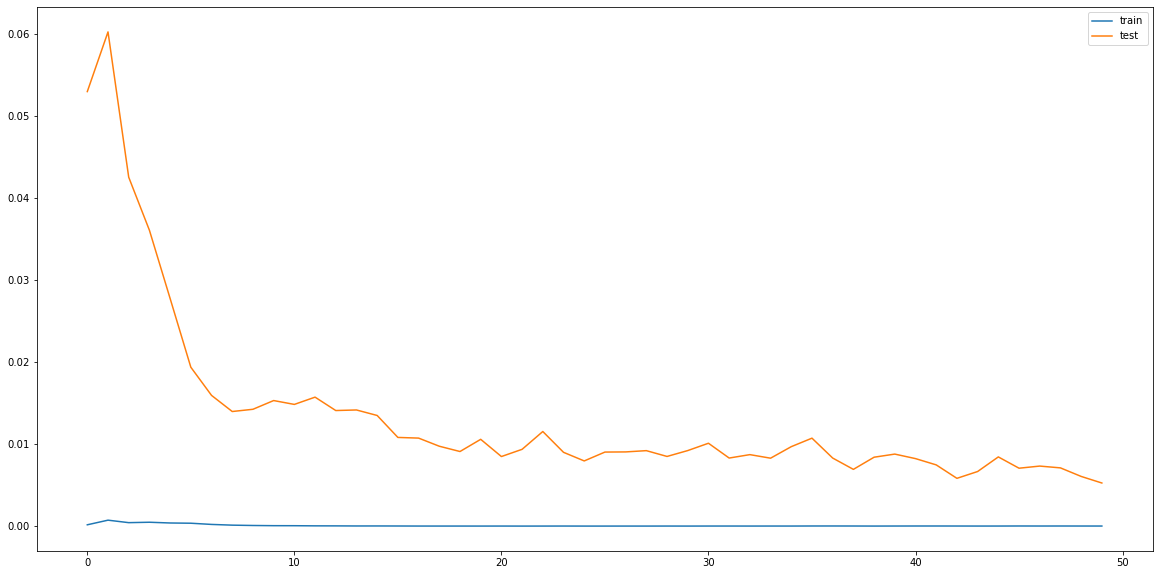

In [8]:
model = Sequential()
model.add(LSTM(units=100,input_shape=(x_train.shape[1],1),return_sequences=True))
model.add(LSTM(units=100))
model.add(Dropout(0.4))
model.add(Dense(1))
ADAM=keras.optimizers.Adam(0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer=ADAM)
history = model.fit(x_train,y_train,epochs=50,batch_size=72,validation_data=(x_test,y_test),verbose=1,shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Predicting on test data

In [9]:
train= new_data[:int(df.shape[0]*0.8)+60]
valid = new_data[int(df.shape[0]*0.8)+60:]
closing_price = model.predict(x_test)
closing_price = scaler.inverse_transform(closing_price)
valid['Predictions'] = closing_price

<ipython-input-9-27dd0c752794>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price


## Calculation error

In [10]:
rmse = np.sqrt(mean_squared_error(np.array(valid['Close']), np.array(valid['Predictions'])))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 63.890


## Plotting test actual and forecast prices

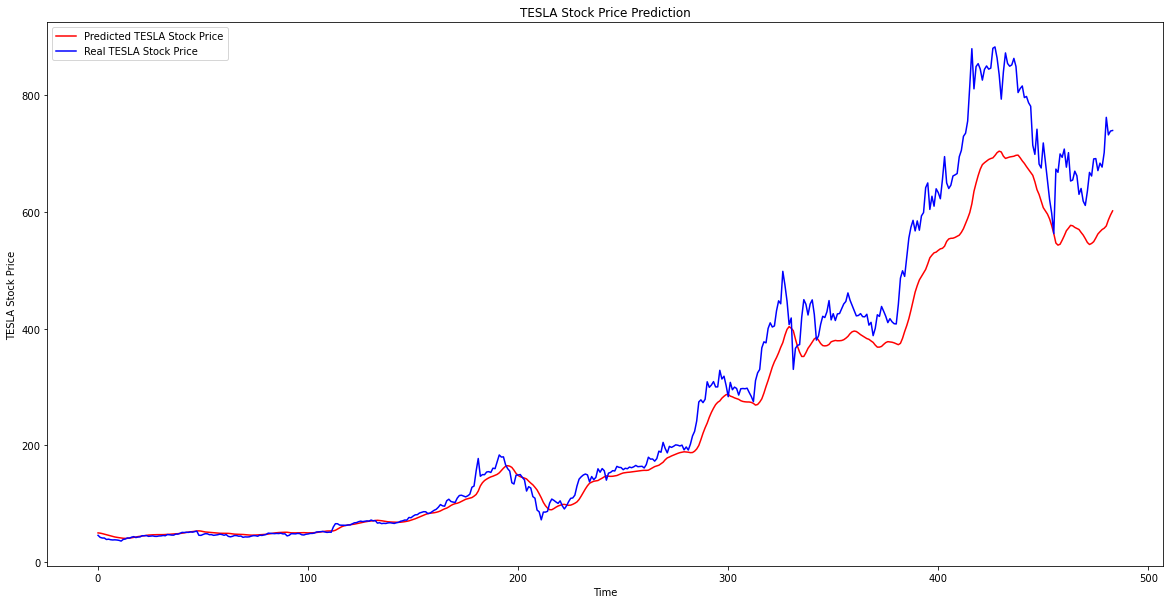

In [11]:
plt.plot(np.array(valid['Predictions']),color = 'red', label = 'Predicted TESLA Stock Price')
plt.plot(np.array(valid['Close']),color = 'blue', label = 'Real TESLA Stock Price')
plt.title('TESLA Stock Price Prediction')
plt.legend()
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.show()

## Plotting actual and forecast prices

<ipython-input-12-24e74933f6a9>:8: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(line2,handles=[patch],loc=2,fontsize=10)


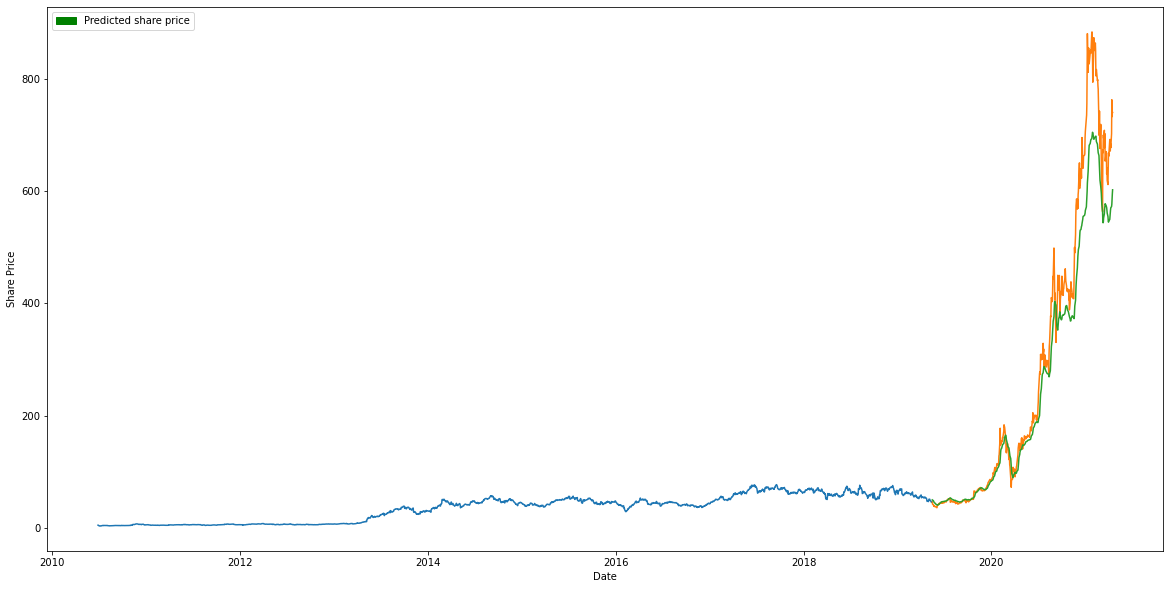

In [12]:
plt.xlabel('Date')
plt.ylabel('Share Price')
plt.plot(train['Close'])
plt.plot(valid['Close'])
line2=plt.plot(valid['Predictions'])
import matplotlib.patches as mpatches
patch=mpatches.Patch(color='green', label='Predicted share price')
plt.legend(line2,handles=[patch],loc=2,fontsize=10)
plt.show()